# Description

This notebook can be use to calibrate cameras using the sunphotometer.

In [1]:
from __future__ import division
%matplotlib inline
import CameraNetwork
from CameraNetwork.sunphotometer import calcAlmucantarPrinciplePlanes
from CameraNetwork.sunphotometer import parseSunPhotoMeter
from CameraNetwork.sunphotometer import readSunPhotoMeter
from CameraNetwork.sunphotometer import findClosestImageTime
from CameraNetwork.sunphotometer import sampleImage
import cPickle
import cv2
import datetime
from dateutil import parser
import ephem
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 16.0)
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
idx = pd.IndexSlice

i:\amit\office backup\amit\studies\cameranetwork\CameraNetwork\transformation_matrices.py:1899: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


## Parse the sunphotometer data

In [2]:
df = parseSunPhotoMeter(r'../../data/aeronet/2016_oct/161001_161031_Technion_Haifa_IL.alm')
date = '2016-10-19'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]
spm_df[2]

,Wavelength(um),SolarZenithAngle(degrees),0.000000,-6.000000,-5.000000,-4.000000,-3.500000,-3.000000,-2.500000,-2.000000,...,-3.000000.1,-2.500000.1,-2.000000.1,2.000000.1,2.500000.1,3.000000.1,3.500000.1,4.000000.1,5.000000.1,6.000000.2
Date(dd-mm-yyyy)_Time(hh:mm:ss),,,,,,,,,,,,,,,,,,,,,
2016-10-19 08:31:26,0.4405,44.789558,-100,42.200193,53.200549,70.826849,83.885750,101.512051,-100.0,-100.0,...,101.512051,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2016-10-19 09:31:26,0.4405,42.987677,-100,43.422572,54.808936,71.727657,84.271955,101.833974,-100.0,-100.0,...,101.833974,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2016-10-19 10:31:28,0.4405,45.818799,-100,48.182799,62.914256,87.166480,106.079354,133.097746,-100.0,-100.0,...,133.097746,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2016-10-19 11:31:24,0.4405,52.517838,-100,40.398869,52.685786,74.300467,90.961784,113.991712,-100.0,-100.0,...,113.991712,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2016-10-19 12:31:43,0.4405,61.882301,-100,35.252294,43.743722,58.153419,69.282337,84.849956,-100.0,-100.0,...,84.849956,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2016-10-19 13:27:36,0.4405,71.986970,-100,35.187754,42.714202,56.416198,66.901762,81.761673,-100.0,-100.0,...,81.761673,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2016-10-19 14:01:15,0.4405,78.480168,-100,30.234378,36.088268,45.866194,53.714267,64.778762,-100.0,-100.0,...,64.778762,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


## Connect to the cameras offline

In [3]:
cams = CameraNetwork.CLIclient()
proxy_params = CameraNetwork.retrieve_proxy_parameters(local_mode=True)
cams.start(proxy_params)

C:\Anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Adding the new server: 102
Adding the new server: 103
Adding the new server: 101
Adding the new server: 106
Adding the new server: 107
Adding the new server: 104
Adding the new server: 105


In [4]:
qdf_102 = cams.query('102', date)

## Visualize one time.

In [5]:
def sampleData(spm_df, t, camera_df, cam_id='102', resolution=301):
    """Samples almucantar rgb values of some camera at specific time."""
    
    angles, values = readSunPhotoMeter(spm_df, t)
    closest_time = findClosestImageTime(camera_df, t, hdr='2')
    img, img_data = cams.seek(cam_id, closest_time, -1, resolution)
    samples, almucantar_angles, almucantar_coords  = sampleImage(img, img_data, almucantar_angles=angles)
    
    #
    # Visualize the sampling positions
    #
    for x, y in zip(almucantar_coords[0], almucantar_coords[1]):
        cv2.circle(img, (int(x), int(y)), 2, (255, 255, 0))

    return angles, values, samples, img, closest_time

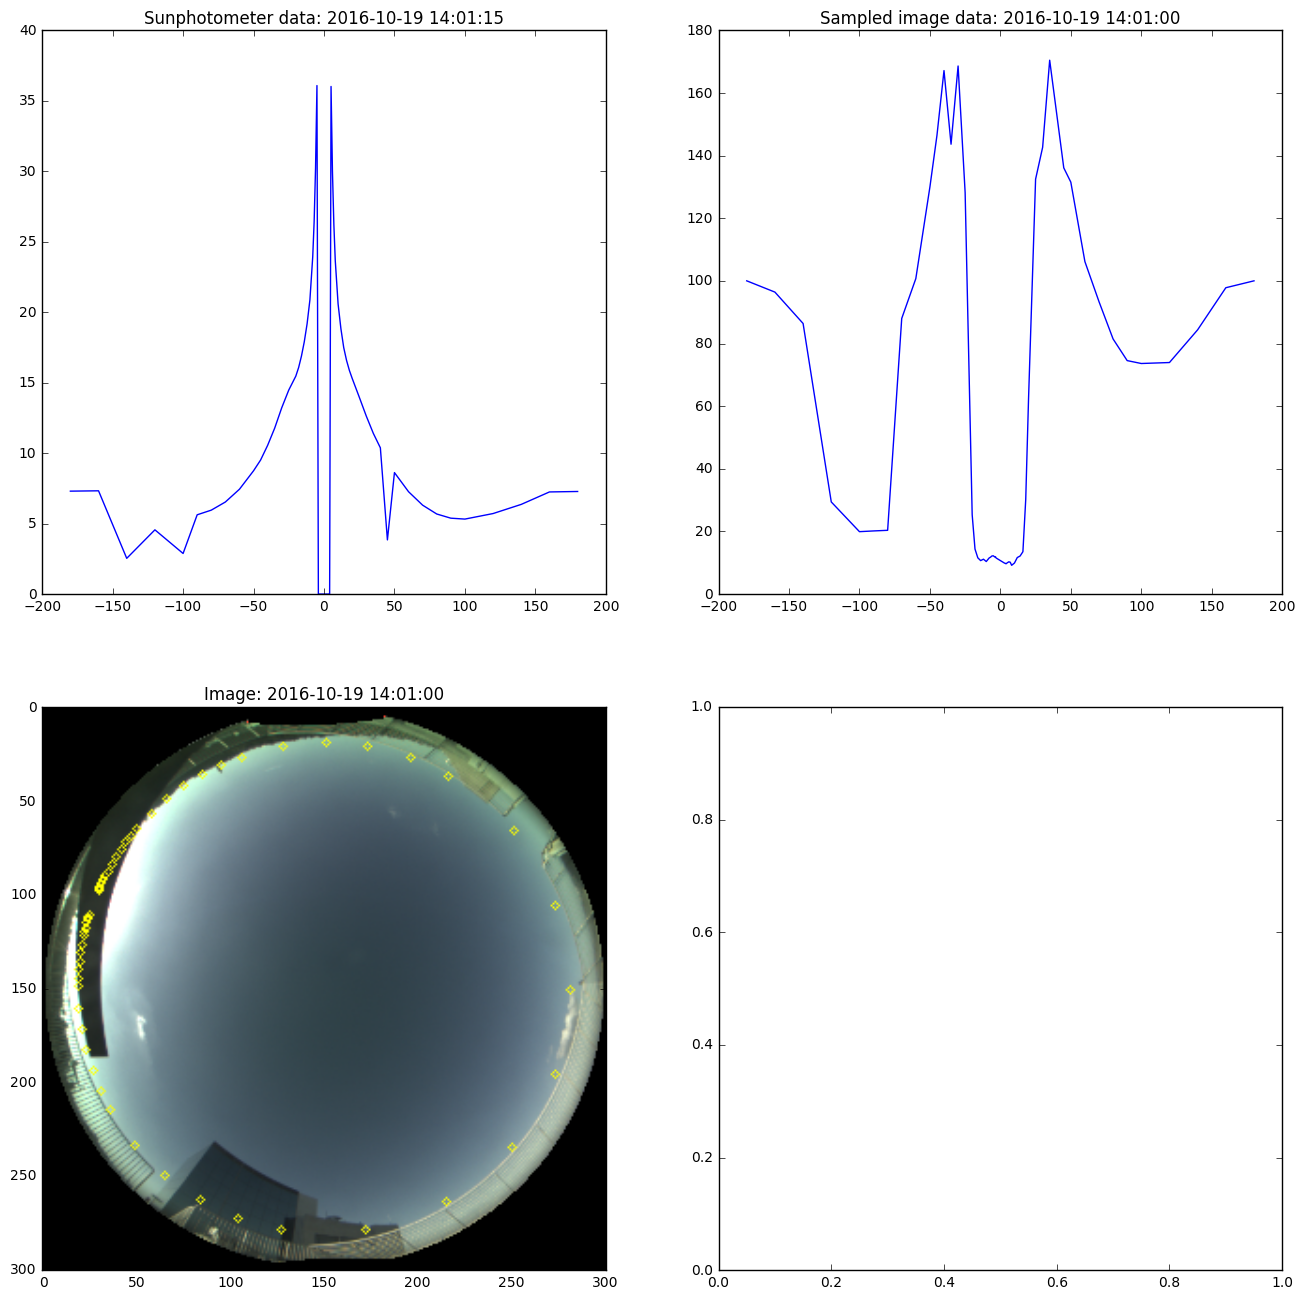

In [15]:
f, axes = plt.subplots(2, 2)
t = spm_df[2].index[-1]
angles, values, samples, img, closest_time = sampleData(spm_df[2], t, qdf_102)
axes[0, 0].plot(angles, values)
axes[0, 0].set_title('Sunphotometer data: {}'.format(t))
axes[0, 1].plot(angles, samples[:, 2])
axes[0, 1].set_title('Sampled image data: {}'.format(closest_time))
axes[1, 0].imshow(np.clip((img/200), 0, 1)**0.6)
axes[1, 0].set_title('Image: {}'.format(closest_time))

## Fit a model to specific time

In [29]:
models = []
for i in range(3):
    t = spm_df[i].index[-3]
    angles, values, samples, img, closest_time = sampleData(spm_df[i], t, qdf_102)
    model = make_pipeline(PolynomialFeatures(degree=1), RANSACRegressor(residual_threshold=5))
    model.fit(samples[:, i].reshape((-1, 1)), values)
    models.append(model)

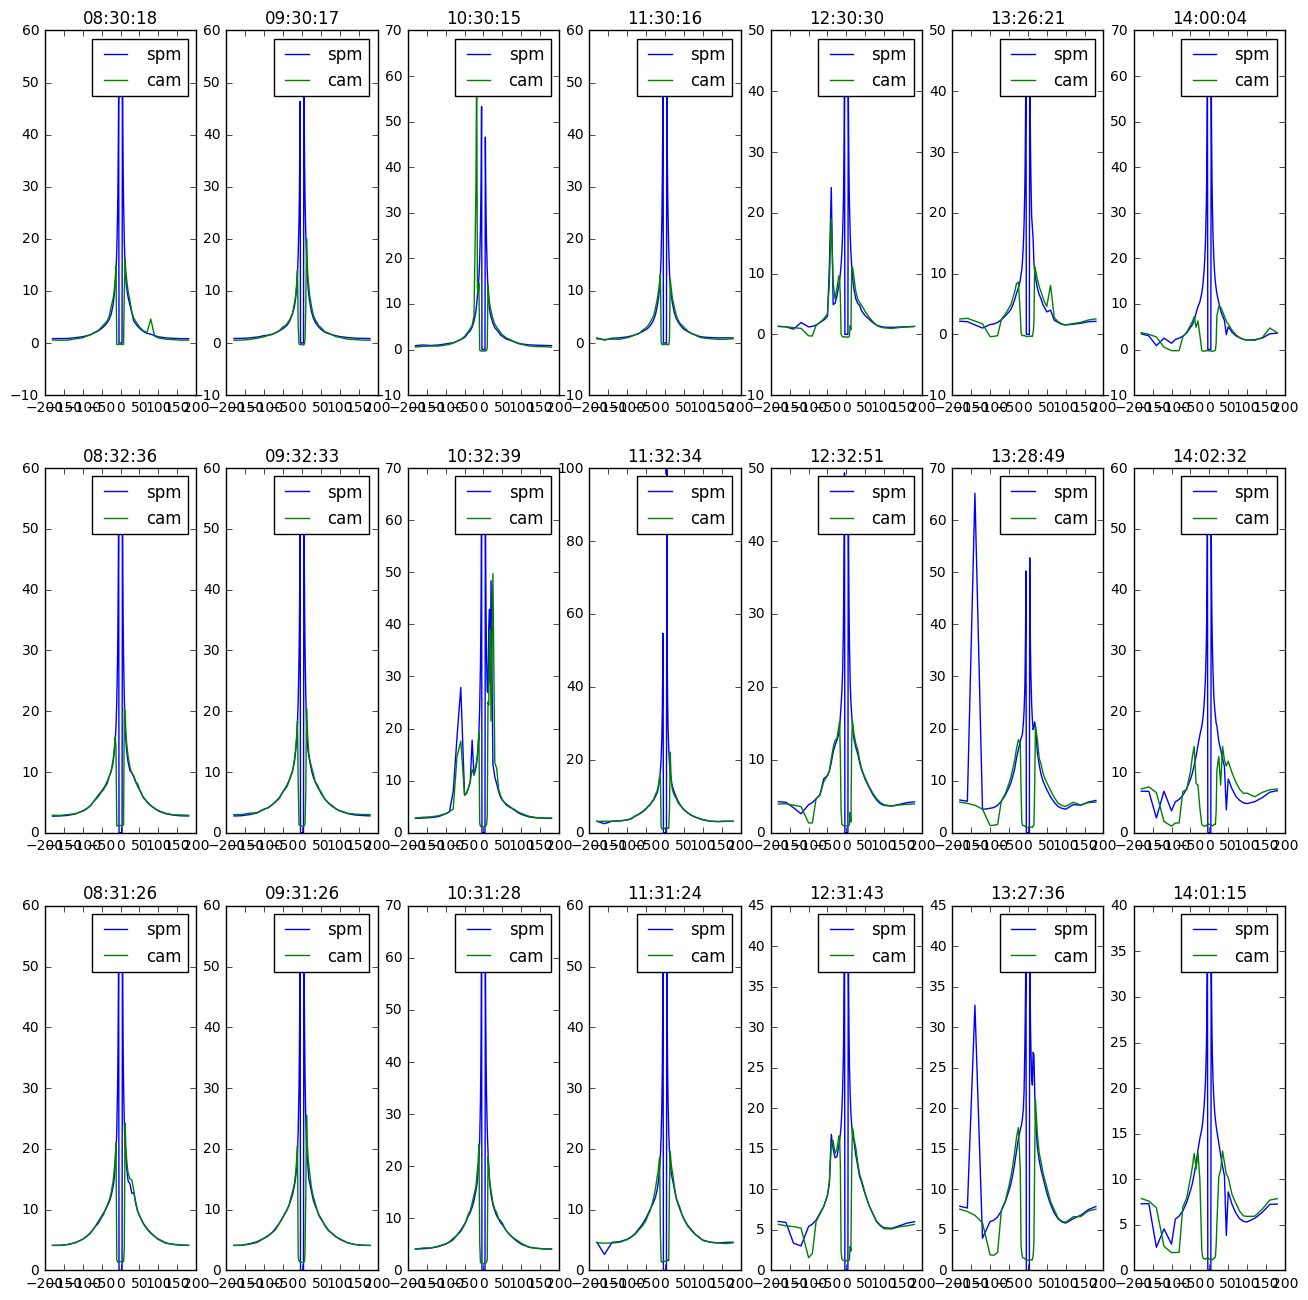

In [30]:
f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

In [31]:
cam_102 = []
for model in models:
    cam_102.append(model.steps[1][1].estimator_.coef_[1])
with open("cam_102_sunphotometer_ratios.pkl", 'wb') as f:
    cPickle.dump(cam_102, f)

## Compare to all cameras

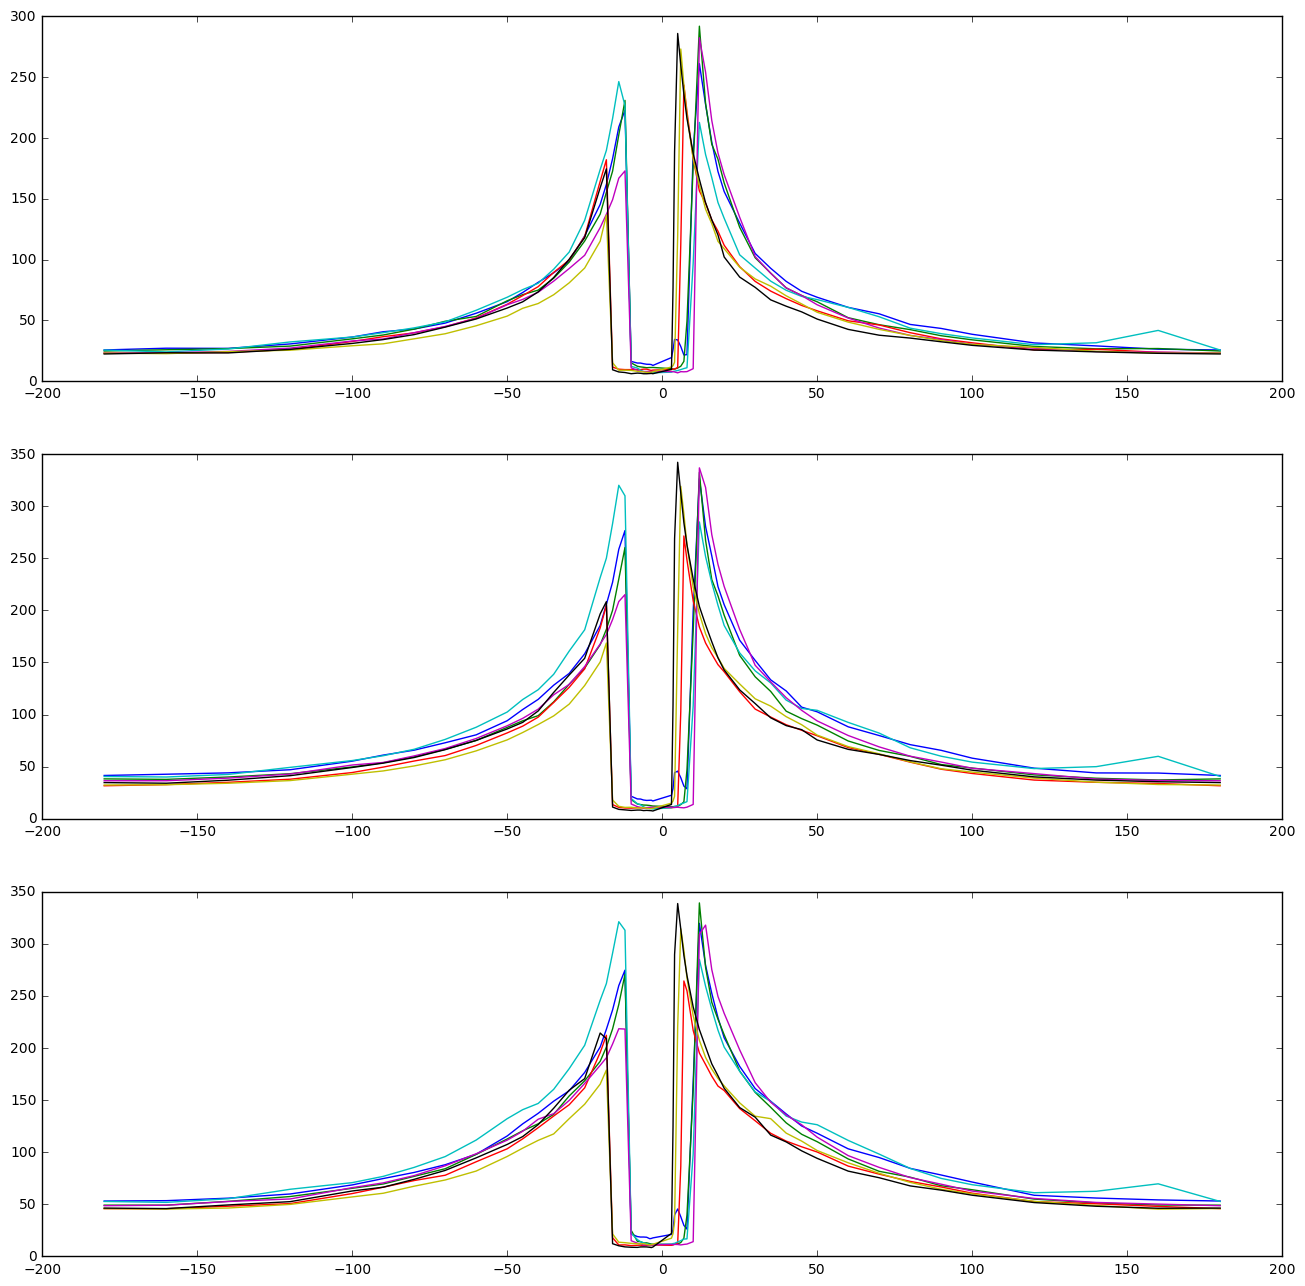

In [25]:
date = '2016-10-19'
f, axes = plt.subplots(3, 1)
t = spm_df[2].index[1]
cam_models = []
cam_samples = []
for i in range(1, 8):
    cam_id = '10{}'.format(i)
    cam_df = cams.query(cam_id, date)
    angles, _, samples, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)
    cam_samples.append(samples)
    for j in range(3):
        axes[j].plot(angles, samples[:, j])

## Fit all cameras to Cam 102 based on the Almucantar

In [26]:
date = '2016-10-19'
t = spm_df[2].index[3]
print t
cam_id = '102'
cam_df = cams.query(cam_id, date)
angles, _, samples_102, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)

def is_valid(X, y):
    return np.all((y > 20) & (y < 150))

cam_models = dict()
cam_samples = dict()
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    print(cam_id)
    cam_df = cams.query(cam_id, date)
    angles, _, samples, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)
    models = []
    for j in range(3):
        model = make_pipeline(PolynomialFeatures(degree=1), RANSACRegressor(residual_threshold=5, max_trials=1000, is_data_valid=is_valid))
        model.fit(samples[:, j].reshape((-1, 1)), samples_102[:, j].reshape((-1, 1)))
        models.append(model)
    cam_models[cam_id] = models
    cam_samples[cam_id] = samples

2016-10-19 11:31:24
101
103
104
105
106
107


On the left is before fitting on the right after the fitting.

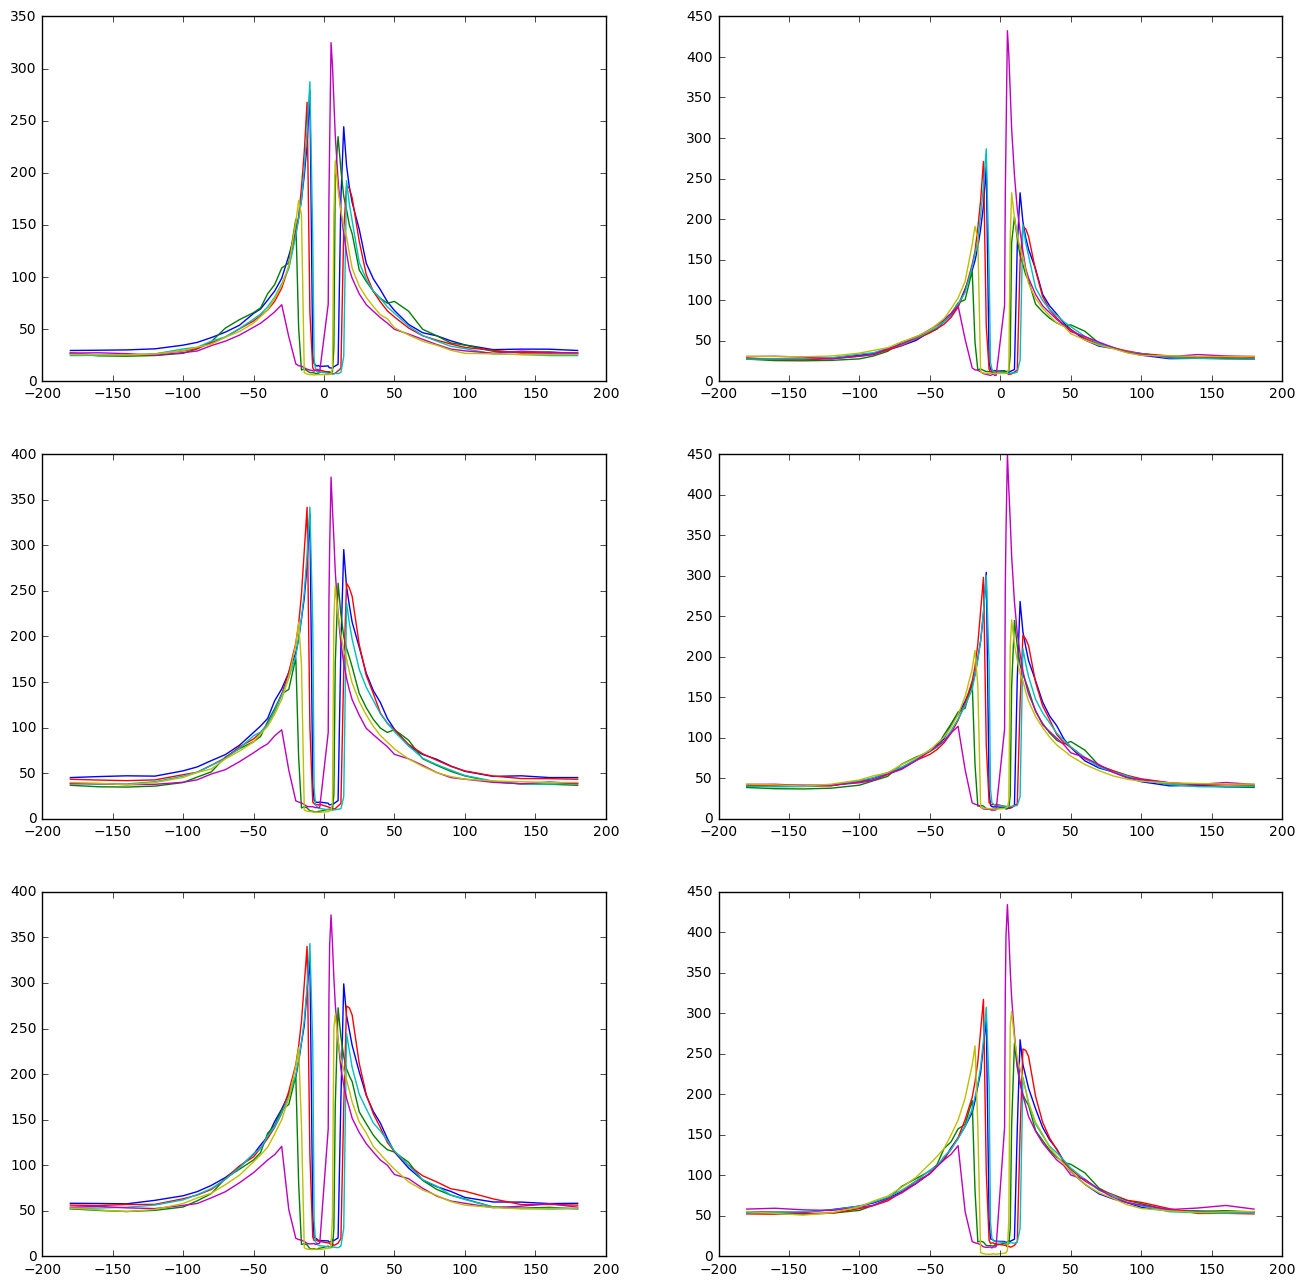

In [59]:
f, axes = plt.subplots(3, 2)
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    for j in range(3):
        models = cam_models[cam_id]
        samples = cam_samples[cam_id]
        tmp = models[j].predict(samples[:, j].reshape(-1, 1))
        axes[j, 0].plot(angles, cam_samples[cam_id][:, j])
        axes[j, 1].plot(angles, tmp)

## Ratio between each camera and camera 102 according to Almucantar

In [77]:
cam_ids, R, G, B = [], [], [], []
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    cam_ids.append(cam_id)
    R.append(cam_models[cam_id][0].steps[1][1].estimator_.coef_[0][1])
    G.append(cam_models[cam_id][1].steps[1][1].estimator_.coef_[0][1])
    B.append(cam_models[cam_id][2].steps[1][1].estimator_.coef_[0][1])
    
pd.DataFrame({'R':R, 'G': G, 'B': B}, index=cam_ids, columns=('R', 'G', 'B'))

,R,G,B
101,0.957016,0.914628,0.883177
103,0.843381,0.929400,0.943916
104,1.008111,0.859776,0.932540
105,0.987771,0.857663,0.872829
106,1.349310,1.211447,1.172096
107,1.087380,0.938838,1.162573


## Elbit results

Here we load Elbit calibration data that was calculated using the 'scripts_calibrate/analyze_elbit_measurements.py' script. This data is used to measure the radiometric response of each camera to camera 102.

In [27]:
CAM_MAP = {
    "4102820388": "cam_101",
    "4102820378": "cam_102",
    "4102820395": "cam_103",
    "4102820374": "cam_104",
    "4102820391": "cam_105",
    "4102820375": "cam_106",
    "4102820392": "cam_107",
}

with open('../../scripts_calibrate/elbit_results.pkl', 'rb') as f:
    data = cPickle.load(f)

cam_ids, R, G, B = [], [], [], []
for cam_id in sorted(CAM_MAP.values()):
    cam_ids.append(cam_id)
    cam_serial=list(CAM_MAP.keys())[list(CAM_MAP.values()).index(cam_id)]
    tmp = np.array(data["4102820378"])/np.array(data[cam_serial])
    R.append(tmp[0])
    G.append(tmp[1])
    B.append(tmp[2])

pd.DataFrame({'R':R, 'G': G, 'B': B}, index=cam_ids, columns=('R', 'G', 'B'))

,R,G,B
cam_101,1.051797,0.965710,1.005324
cam_102,1.000000,1.000000,1.000000
cam_103,0.966785,0.992743,0.979552
cam_104,0.961387,0.908698,0.941777
cam_105,1.108716,1.005257,1.056330
cam_106,1.115198,1.062346,1.079133
cam_107,1.198078,1.103405,1.130218


## Calculate Radiometric calibration for cameras

We use the sunphotometer to calibrate the camera 102. Then we use the elbit ratios to calibrate the rest of the cameras to 102 and the sunphotometer.

In [38]:
#
# Load the Elbit camera ratios.
#
with open("cam_102_sunphotometer_ratios.pkl", 'rb') as f:
    ratios = cPickle.load(f)

#
# Save calibration to home folders of the cameras.
#
base_path = r'D:\data\experiment_sukot_2016'
for cam_id in sorted(CAM_MAP.values()):
    cam_serial=list(CAM_MAP.keys())[list(CAM_MAP.values()).index(cam_id)]
    tmp = np.array(data["4102820378"])/np.array(data[cam_serial])
    with open(os.path.join(base_path, cam_id, '.radiometric.pkl'), 'wb') as f:
        cPickle.dump(dict(ratios=(tmp[0]*ratios[0], tmp[1]*ratios[1], tmp[2]*ratios[2])), f)